# Northwind Trades ® - Enhancing Product Recommendations and Warehouse Efficiency through Data-Driven Analytics
## Part 3: Optimal Warehouse Design with Community-Driven Algorithm

### The Streamlined Warehouse Blueprint

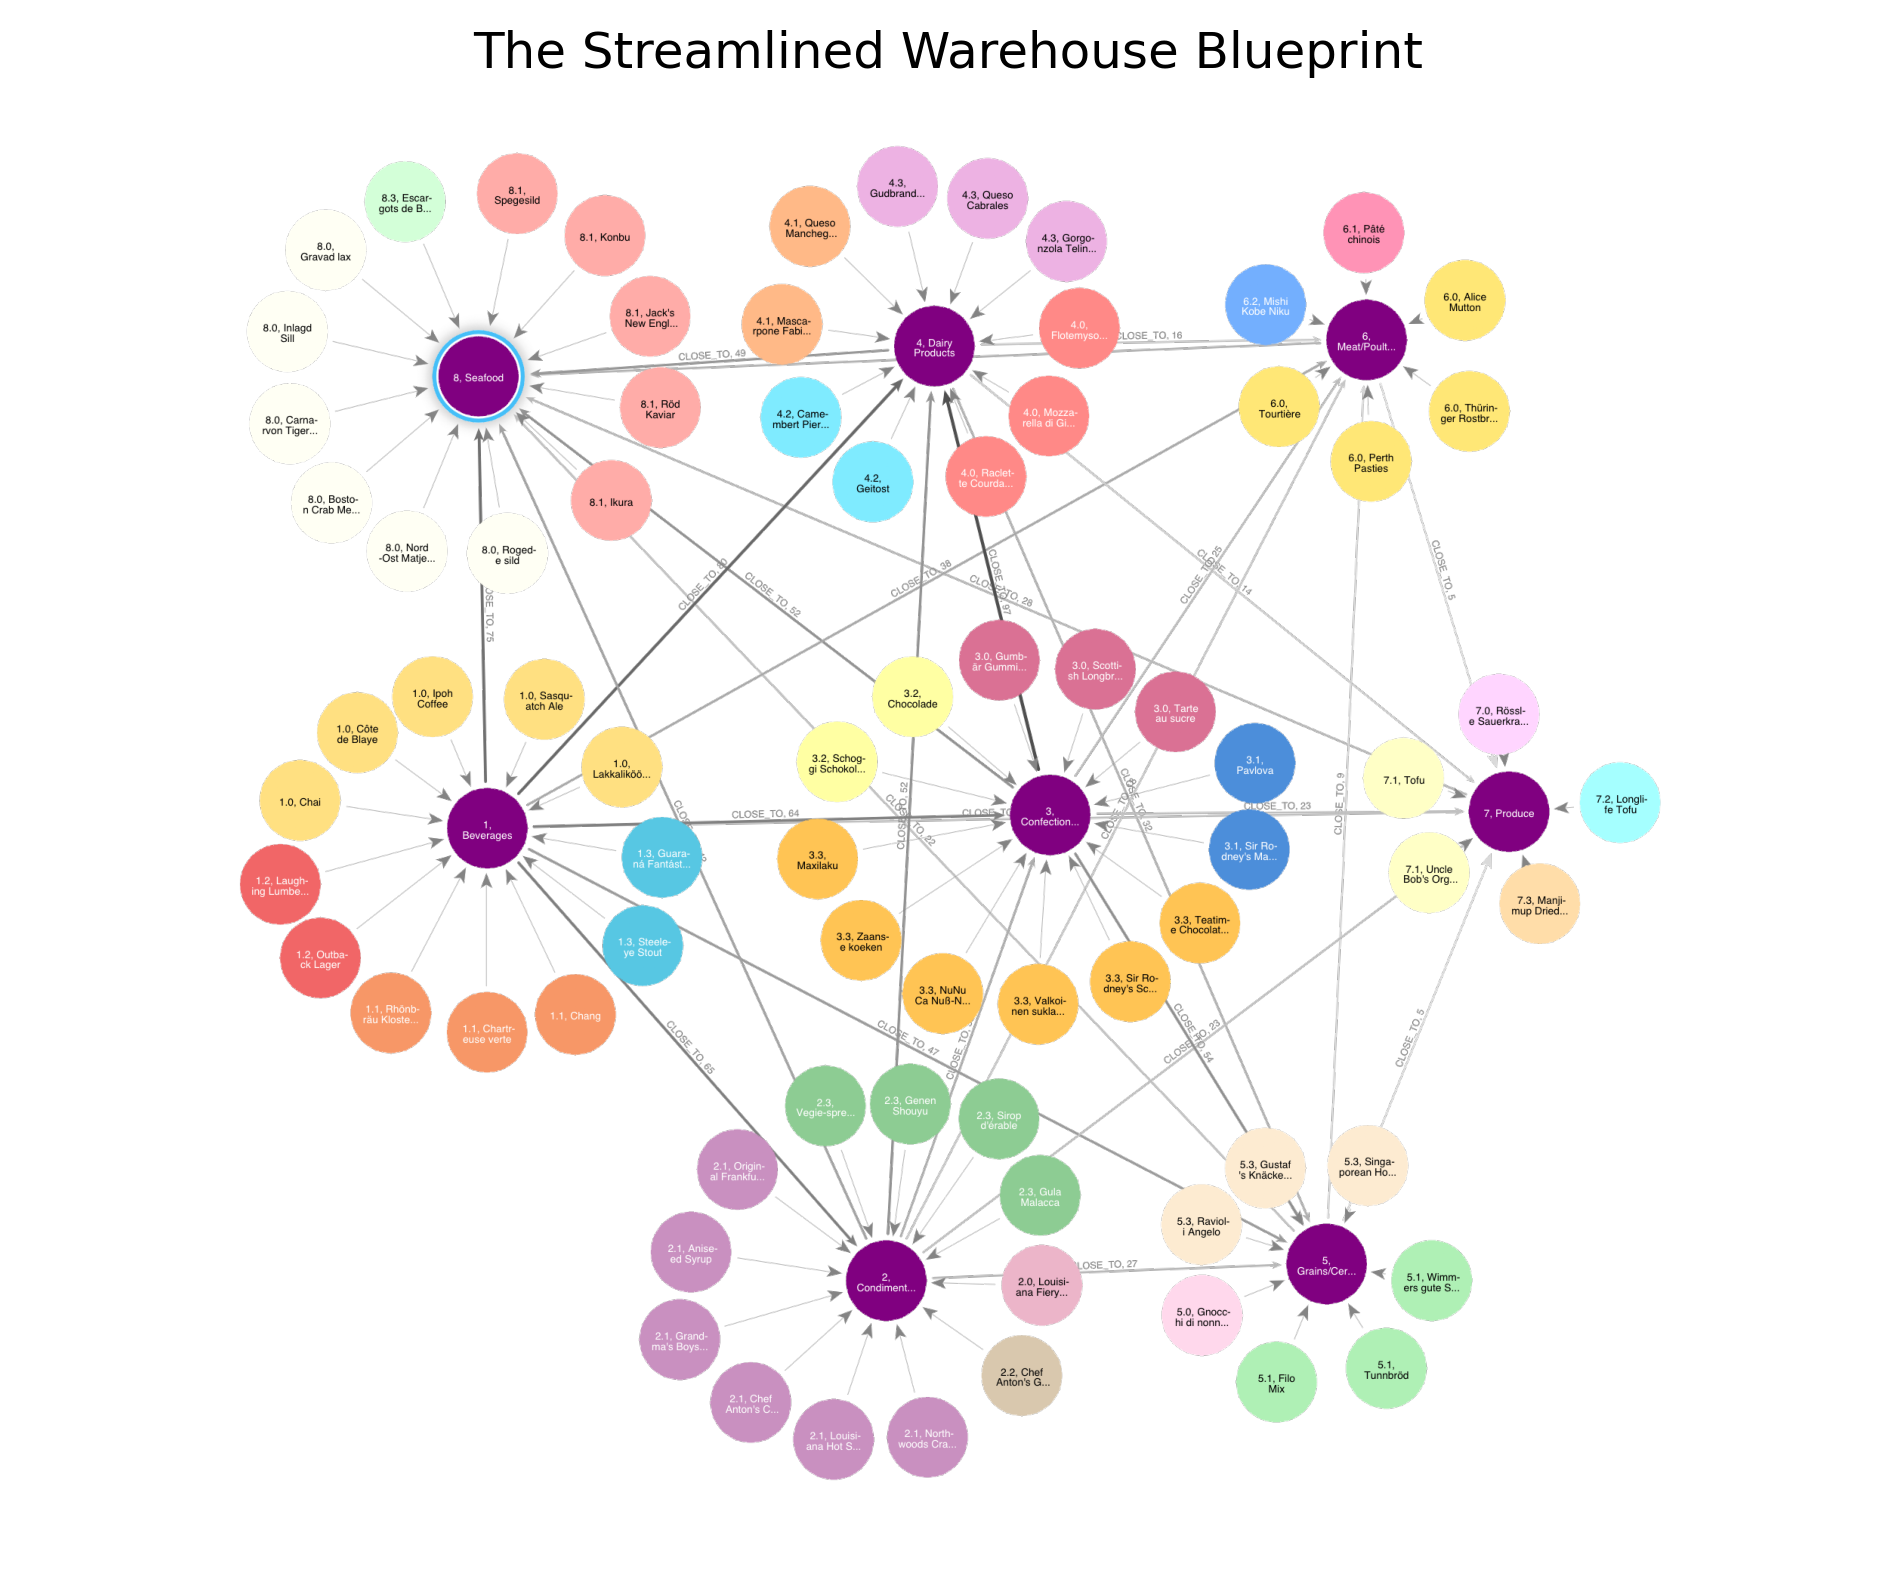

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def show_image(image_path: str, title: str, dpi: int = 300) -> None:
    img = mpimg.imread(image_path)
    plt.figure(dpi=dpi, figsize=(img.shape[1] / dpi, img.shape[0] / dpi))
    plt.title(title)

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Remove the axis (borders)
    plt.axis('off')

    plt.imshow(img)
    plt.show()


show_image("images/warehouse.png", "The Streamlined Warehouse Blueprint", dpi=300)

### Optimal Warehouse Design

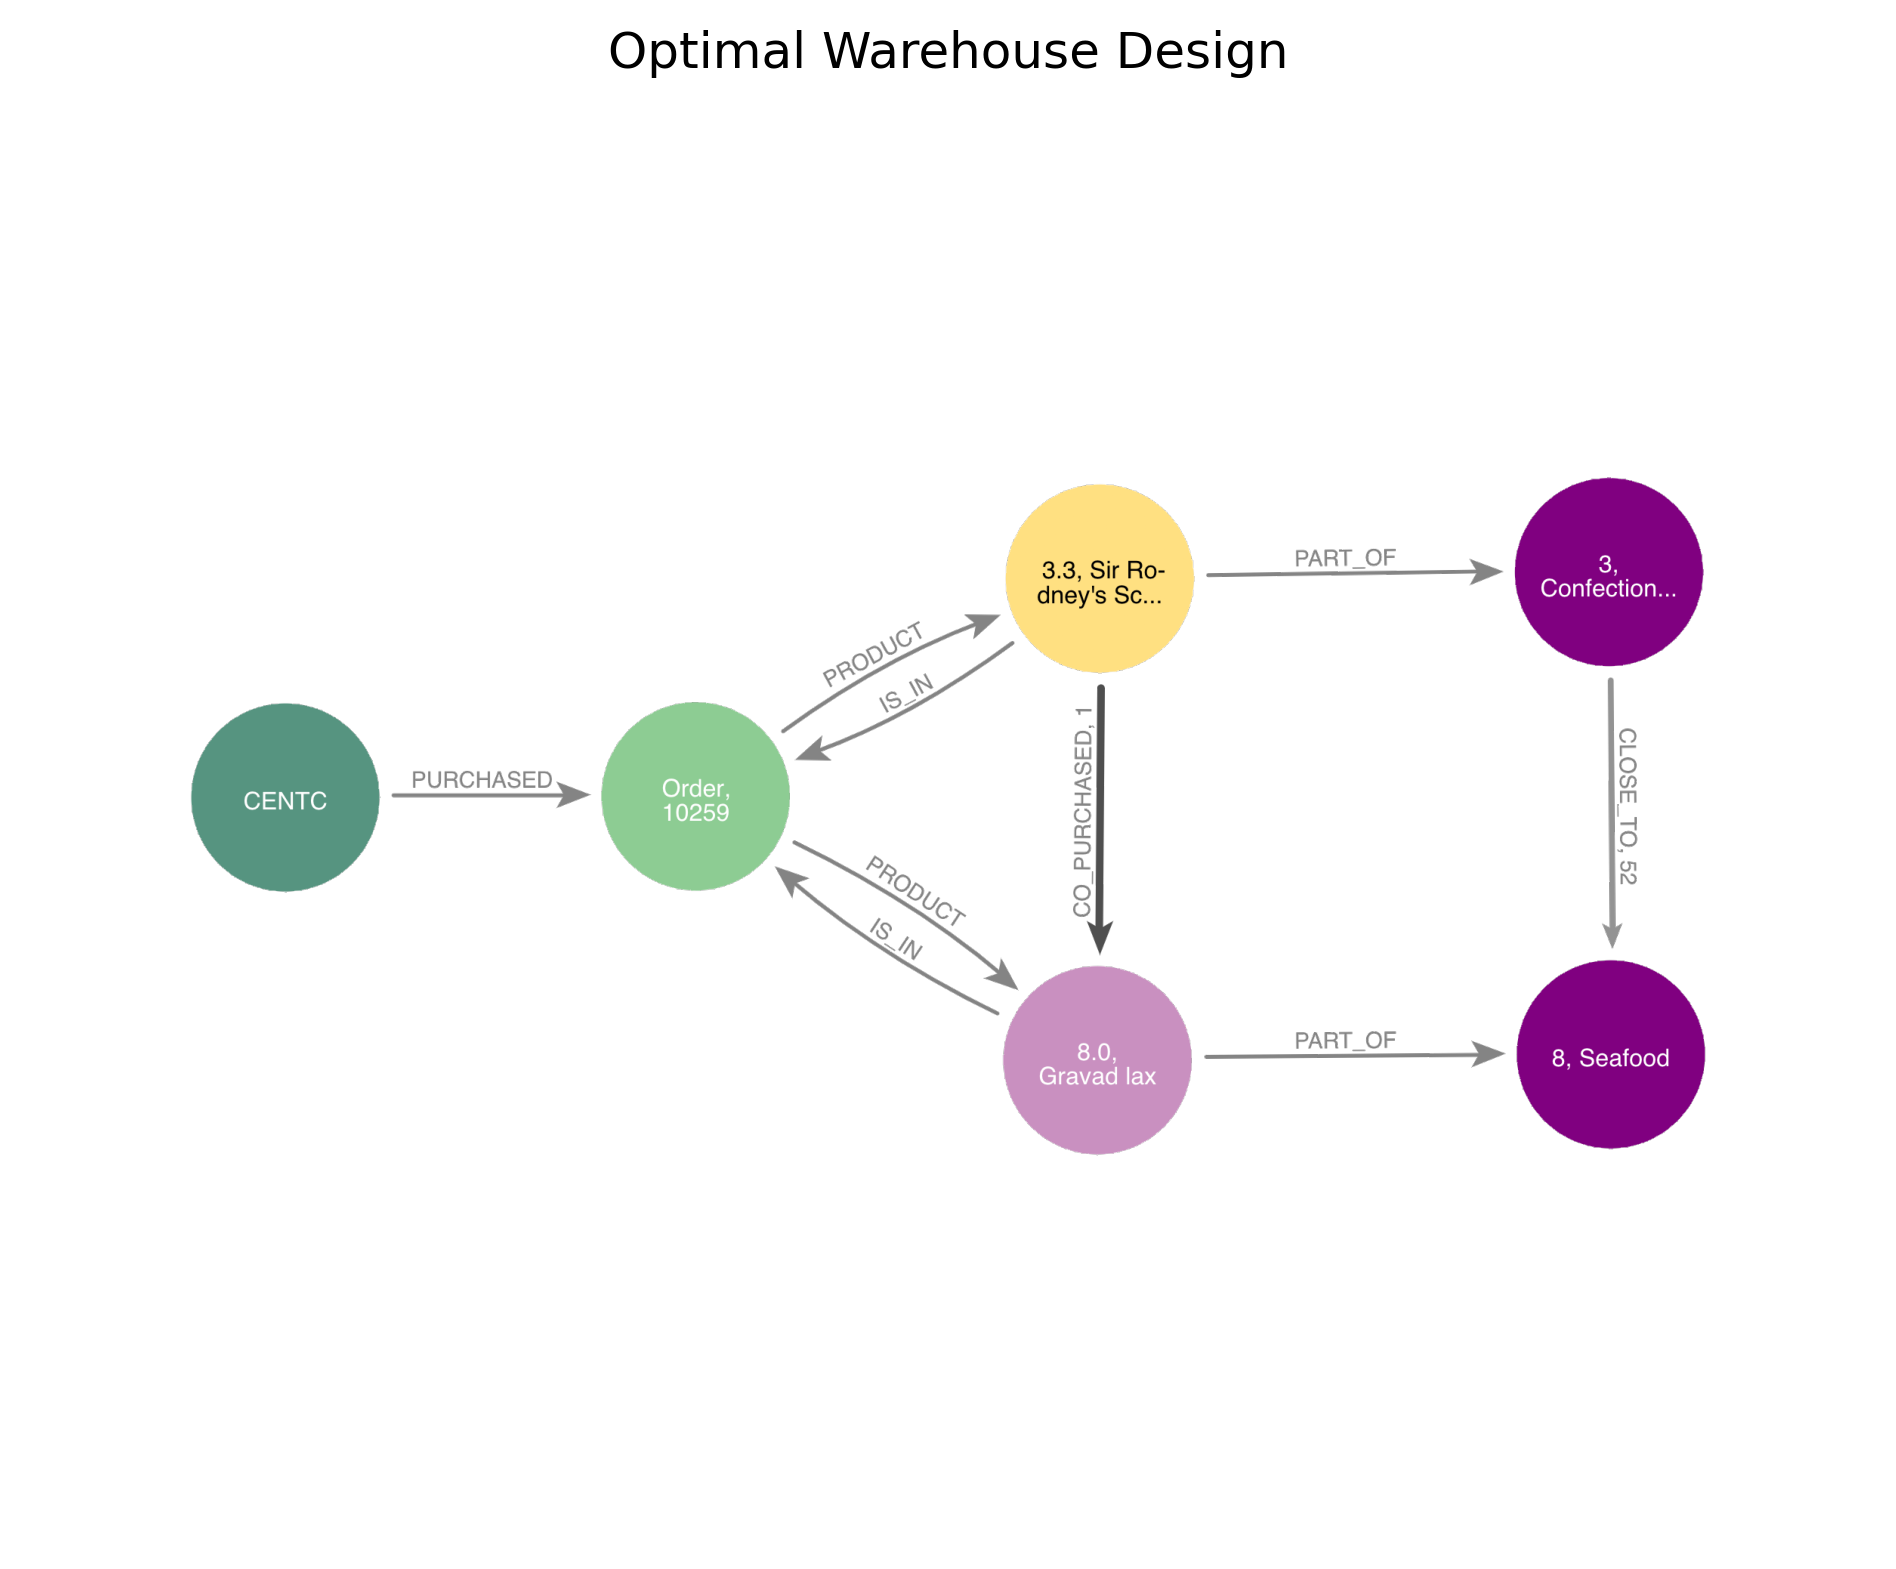

In [2]:
show_image("images/warehouse_intuition.png", "Optimal Warehouse Design", dpi=300)

### Included Modules, Packages, and Supporting Functions

In [3]:
import getpass
import platform

import pandas as pd
from neo4j import Session, Driver, GraphDatabase


def generate_neo4j_local_driver() -> Driver:
    if platform.system() == "Darwin" and getpass.getuser() == "honghu":
        return GraphDatabase.driver(uri="bolt://localhost:7689", auth=("neo4j", "ucb_mids_w205"))
    else:
        return GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))


def generate_neo4j_local_session(driver: Driver, database: str = "neo4j") -> Session:
    return driver.session(database=database)

def my_neo4j_run_query_pandas(query: str, session: Session, **kwargs) -> pd.DataFrame:
    """
    Run a query and return the results in a pandas DataFrame.

    :param query: The Cypher query to be executed.
    :param session: The Neo4j session to use for running the query.
    :param kwargs: Additional parameters to pass to the session.run() method.
    :return: A pandas DataFrame containing the query results.
    """
    result = session.run(query, **kwargs)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

def my_neo4j_wipe_out_project(session, project_name: str = 'ds_graph') -> None:
    """
    Wipes out the Neo4j project by dropping the 'ds_graph' graph.

    :param session: The Neo4j session to run the queries.
    :param project_name: The name of the project to be wiped
    """
    query = f"CALL gds.graph.drop('{project_name}', false) yield graphName"
    session.run(query)


driver = generate_neo4j_local_driver()
neo4j_session = generate_neo4j_local_session(driver)
my_neo4j_wipe_out_project(neo4j_session)

### Derive Undirected `CO_PURCHASED` Edges between Products and Products
The weighted `CO_PURCHASED` relationship (undirected) identifies how many times two products were purchased together in the same order. The higher weight of the `CO_PURCHASED` relationship, the more frequently the two products were purchased together.

In [4]:
cypher_exec = """
MATCH (p1:Product)-[r1:IS_IN]->(o:Order)<-[r2:IS_IN]->(p2:Product)
	WHERE p1.id < p2.id
WITH p1, p2, count(o) AS co_purchased
MERGE (p1)-[s:CO_PURCHASED]-(p2)
	ON CREATE SET s.cnt = co_purchased
	ON MATCH SET s.cnt = co_purchased
;
"""
neo4j_session.run(cypher_exec)

params_template = {
    "is_two_way": True,
    "beg_node_label": "Product",
    "end_node_label": "Product",
    "edge_name": "CO_PURCHASED",
    "edge_weight": "cnt"
}
cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']}) 
RETURN n1.product_name as one_product_name, r.{params_template['edge_weight']} as co_purchased_count, n2.product_name as other_product_name
ORDER BY r.{params_template['edge_weight']} DESC
"""
print(cypher_query)
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)


MATCH (n1:Product)-[r:CO_PURCHASED]-(n2:Product) 
RETURN n1.product_name as one_product_name, r.cnt as co_purchased_count, n2.product_name as other_product_name
ORDER BY r.cnt DESC



,one_product_name,co_purchased_count,other_product_name
0,Sir Rodney's Scones,8,Sirop d'érable
1,Sirop d'érable,8,Sir Rodney's Scones
2,Pavlova,7,Gorgonzola Telino
3,Gorgonzola Telino,7,Pavlova
4,Pavlova,6,Tarte au sucre
...,...,...,...
3065,Mozzarella di Giovanni,1,Aniseed Syrup
3066,Mozzarella di Giovanni,1,Gnocchi di nonna Alice
3067,Mozzarella di Giovanni,1,Côte de Blaye
3068,Mozzarella di Giovanni,1,Rhönbräu Klosterbier


### Assign Community to Each Product Node Based on `CO_PURCHASED` Edges by Louvain Algorithm

In [5]:
cypher_exec = """
CALL gds.graph.project('ds_graph', 'Product', {CO_PURCHASED: {properties: 'cnt', orientation: 'UNDIRECTED'}})
;
"""
neo4j_session.run(cypher_exec)

cypher_exec = """
CALL gds.louvain.stream('ds_graph', { includeIntermediateCommunities: false, consecutiveIds: true, relationshipTypes: ['CO_PURCHASED'], maxIterations: 30, maxLevels: 30 })
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS n, communityId
SET n.community = communityId
;
"""
neo4j_session.run(cypher_exec)

cypher_query = """
MATCH (p:Product)
RETURN p.community AS community_id, COUNT(*) AS community_count
ORDER BY community_id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,community_id,community_count
0,0,25
1,1,20
2,2,32


### Create Combined Community ID based on Category plus Community Calculated by Louvain Algorithm

The communityId calculated by the Louvain algorithm is considering product category. Some product categories like dairy products, seafood should be stored in freezer. Some product categories like Grains/Cereals, Condiments should be stored in dry storage. Some product categories like Meat/Poultry, Produce should be stored in cooler. The communityId calculated by the Louvain algorithm is not considering these factors. We need to combine the communityId calculated by the Louvain algorithm with the product category to create a new communityId.

In [6]:
cypher_exec = """
MATCH (p:Product)-[r:PART_OF]->(c:Category)
WITH p, c
SET p.community = c.id + '.' + p.community
;
"""
neo4j_session.run(cypher_exec)

cypher_query = """
MATCH (p:Product)
RETURN p.community AS community_id, COUNT(*) AS community_size
ORDER BY community_id
"""
df = my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)
df

,community_id,community_size
0,1.0,2
1,1.1,4
2,1.2,6
3,2.0,7
4,2.1,4
5,2.2,1
6,3.0,2
7,3.1,5
8,3.2,6
9,4.0,3


### Hybrid Community ID Example

In the following example, `8` in `8.0` means the main modularity which is the category id of `seafood`. The `0` in `8.0` means the sub modularity which is equal to the Louvain community id.

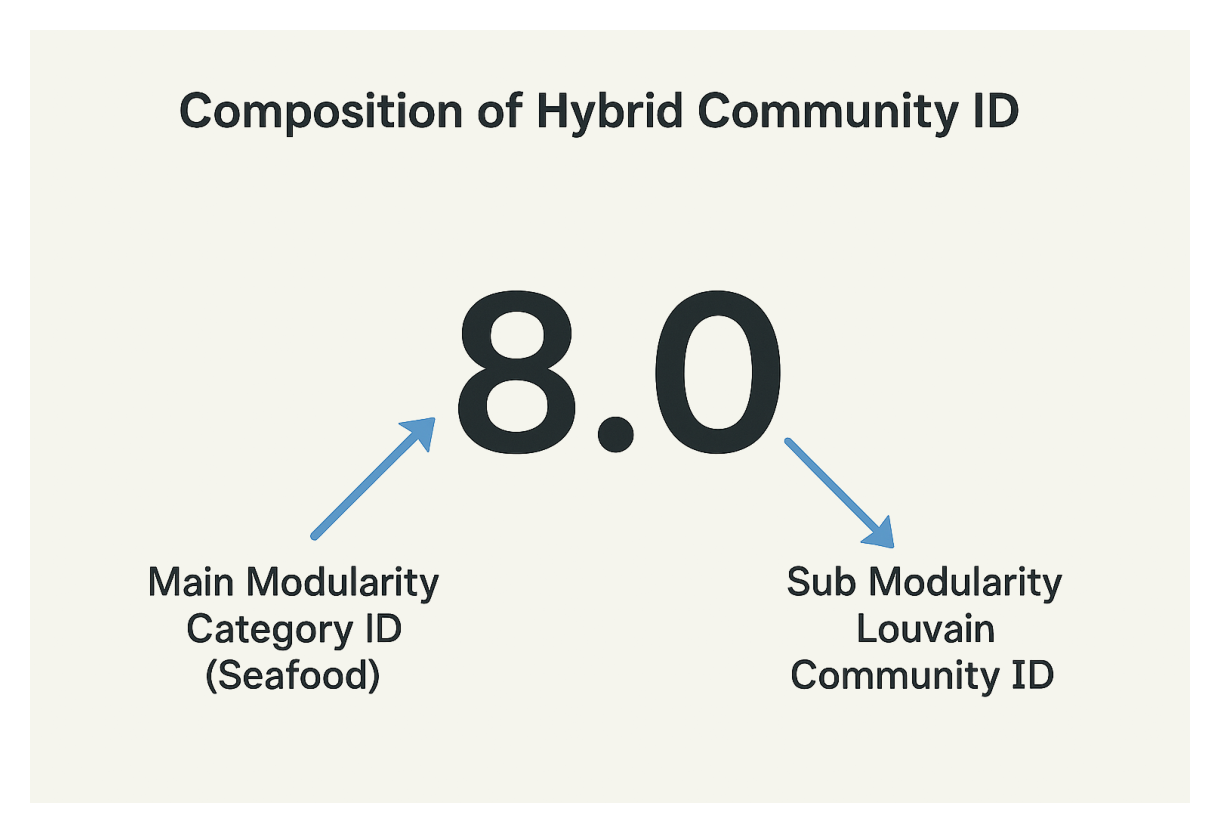

In [7]:
show_image("images/hybrid_community_id.png", "", dpi=300)

In [8]:
from IPython.display import Markdown as md

text = f"""
### Derive Undirected `CLOSE_TO` Edges between Categories and Categories

Even through we have {len(df)} communities after combining the community calculated by the Louvain algorithm with the product category, we still need to store the products with the same category in the same area, but how close the categories should be stored to each other? We set up an undirected `CLOSE_TO` relationship to determine the proximity for storing two categories. The weight of this `CLOSE_TO` connection reflects the number of product pairs from both categories found in the same orders.
"""
md(text)


### Derive Undirected `CLOSE_TO` Edges between Categories and Categories

Even through we have 23 communities after combining the community calculated by the Louvain algorithm with the product category, we still need to store the products with the same category in the same area, but how close the categories should be stored to each other? We set up an undirected `CLOSE_TO` relationship to determine the proximity for storing two categories. The weight of this `CLOSE_TO` connection reflects the number of product pairs from both categories found in the same orders.


In [9]:
cypher_exec = """
MATCH (c1:Category)<-[r1:PART_OF]-(p1:Product)-[r2:IS_IN]->(o:Order)<-[r3:IS_IN]->(p2:Product)-[r4:PART_OF]->(c2:Category)
	WHERE p1.id < p2.id and c1.id < c2.id
WITH c1, c2, count(o) as co_exists
MERGE (c1)-[s:CLOSE_TO]-(c2)
	ON CREATE SET s.cnt = co_exists
	ON MATCH SET s.cnt = co_exists
;
"""
neo4j_session.run(cypher_exec)

params_template = {
    "is_two_way": True,
    "beg_node_label": "Category",
    "end_node_label": "Category",
    "edge_name": "CLOSE_TO",
    "edge_weight": "cnt"
}
cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']}) 
RETURN n1.category_name as one_category_name, r.{params_template['edge_weight']} as co_purchased_count, n2.category_name as other_category_name
ORDER BY r.{params_template['edge_weight']} DESC
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,one_category_name,co_purchased_count,other_category_name
0,Confections,97,Dairy Products
1,Dairy Products,97,Confections
2,Beverages,80,Dairy Products
3,Dairy Products,80,Beverages
4,Beverages,75,Seafood
5,Seafood,75,Beverages
6,Beverages,65,Condiments
7,Condiments,65,Beverages
8,Beverages,64,Confections
9,Confections,64,Beverages
